# timeGAN para HAR

- A implementação original, disponível [aqui](https://github.com/jsyoon0823/TimeGAN/tree/master), usou o TensorFlow v1.
- Uma implementação alternativa usando TensorFlow v2 (com alguns erros) está disponível [aqui](https://www.kaggle.com/code/alincijov/stocks-generate-synthetic-data-timegan).
- Uma implementação usando pytorch foi desenvolvida em 2021 e está disponível [aqui](https://github.com/benearnthof/TimeGAN/tree/main).

A proposta aqui é tentar adaptar o modelo original para dados de sensores inerciais em tarefas de HAR.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow import function, GradientTape, sqrt, abs, reduce_mean, ones_like, zeros_like, convert_to_tensor,float32
from tensorflow import data as tfdata
from tensorflow import config as tfconfig
from tensorflow import nn
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import GRU, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
path = '/content/GOOG.csv'
df = pd.read_csv(path)
df = df.set_index('Date').sort_index()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-25,41.480999,41.788502,41.252998,41.783501,41.736008,29890000
2017-01-26,41.890499,41.900002,41.350498,41.607498,41.560204,59478000
2017-01-27,41.735500,42.097500,41.021999,41.165501,41.118710,59316000
2017-01-30,40.733002,40.792000,39.990002,40.116001,40.070404,64932000
2017-01-31,39.842999,40.062500,39.526001,39.839500,39.794216,43212000


In [ ]:
seq_len = 24
n_seq = 6
hidden_dim = 24
gamma = 1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
train_steps = 50

gan_args = batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim

In [ ]:
def preprocess(data, seq_len):
    ori_data = data[::-1]
    scaler = MinMaxScaler().fit(ori_data)
    ori_data = scaler.transform(ori_data)

    temp_data = []
    for i in range(0, len(ori_data) - seq_len):
        _x = ori_data[i:i + seq_len]
        temp_data.append(_x)

    idx = np.random.permutation(len(temp_data))
    data = []
    for i in range(len(temp_data)):
        data.append(temp_data[idx[i]])

    return data

In [ ]:
stock_data = preprocess(df.values, seq_len)

In [ ]:
def net(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(GRU(units=hidden_units,
                      return_sequences=True,
                      name=f'GRU_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(LSTM(units=hidden_units,
                      return_sequences=True,
                      name=f'LSTM_{i + 1}'))

    model.add(Dense(units=output_units,
                    activation='sigmoid',
                    name='OUT'))
    return model

In [ ]:
class Generator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type

    def build(self, input_shape):
        model = Sequential(name='Generator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim,
                    net_type=self.net_type)
        return model

class Discriminator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type

    def build(self, input_shape):
        model = Sequential(name='Discriminator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=1,
                    net_type=self.net_type)
        return model

class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return

    def build(self, input_shape):
        recovery = Sequential(name='Recovery')
        recovery = net(recovery,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.n_seq)
        return recovery

class Embedder(Model):

    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return

    def build(self, input_shape):
        embedder = Sequential(name='Embedder')
        embedder = net(embedder,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.hidden_dim)
        return embedder

class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim

    def build(self, input_shape):
        model = Sequential(name='Supervisor')
        model = net(model,
                    n_layers=2,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim)
        return model

In [ ]:
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        self.define_gan()

    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        X = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')

        # AutoEncoder
        H = self.embedder(X)
        X_tilde = self.recovery(H)

        self.autoencoder = Model(inputs=X, outputs=X_tilde)

        # Adversarial Supervise Architecture
        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)

        self.adversarial_supervised = Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')


        # Adversarial architecture in latent space
        Y_fake_e = self.discriminator(E_Hat)

        self.adversarial_embedded = Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')

        #Synthetic data generation
        X_hat = self.recovery(H_hat)

        self.generator = Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')


        # Final discriminator model
        Y_real = self.discriminator(H)

        self.discriminator_model = Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")

        # Loss functions
        self._mse=MeanSquaredError()
        self._bce=BinaryCrossentropy()

In [ ]:
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)

    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    @function
    def train_supervisor(self, x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)

        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)

        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)

    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var

    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)

            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)

            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)

        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)

        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())

    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))

    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())

    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))

In [ ]:
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)

In [ ]:
autoencoder_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Emddeding network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_e_loss_t0 = synth.train_autoencoder(X_, autoencoder_opt)

Emddeding network training: 100%|██████████| 50/50 [00:21<00:00,  2.28it/s]


In [ ]:
supervisor_opt = Adam(learning_rate=learning_rate)
for _ in tqdm(range(train_steps), desc='Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    step_g_loss_s = synth.train_supervisor(X_, supervisor_opt)

Supervised network training:   0%|          | 0/50 [00:00<?, ?it/s]


TypeError: Binding inputs to tf.function failed due to `missing a required argument: 'opt'`. Received args: (<tf.Tensor: shape=(128, 24, 6), dtype=float32, numpy=
array([[[0.46754715, 0.46111333, 0.4653351 , 0.45670116, 0.45604038,
         0.20860893],
        [0.46225017, 0.46392646, 0.45685953, 0.44268587, 0.44204536,
         0.21672383],
        [0.43993223, 0.45326552, 0.4402616 , 0.45381564, 0.45315897,
         0.22342923],
        ...,
        [0.36898085, 0.35972434, 0.36263987, 0.35735744, 0.3568404 ,
         0.19585595],
        [0.37820467, 0.36698064, 0.37062097, 0.359075  , 0.35855547,
         0.18285383],
        [0.3911293 , 0.38304085, 0.3808622 , 0.37652537, 0.37598062,
         0.20612863]],

       [[0.23371707, 0.23204783, 0.23121257, 0.22971171, 0.22937934,
         0.18480597],
        [0.22430961, 0.22407238, 0.22343272, 0.22540067, 0.22507456,
         0.20402034],
        [0.2296066 , 0.22237009, 0.22277585, 0.21848232, 0.2181662 ,
         0.47969353],
        ...,
        [0.21290702, 0.21031979, 0.21235096, 0.21116555, 0.21085998,
         0.16426061],
        [0.21689387, 0.21125862, 0.21292306, 0.20854795, 0.20824619,
         0.17716119],
        [0.21038914, 0.20951508, 0.21073358, 0.20989451, 0.20959082,
         0.22330296]],

       [[0.33824247, 0.34030354, 0.33754343, 0.3367776 , 0.33629033,
         0.17852633],
        [0.3323681 , 0.32492152, 0.33146045, 0.3239852 , 0.32351643,
         0.        ],
        [0.32993504, 0.32560584, 0.33002314, 0.3217627 , 0.32129717,
         0.1172315 ],
        ...,
        [0.3457483 , 0.33611208, 0.34114733, 0.33517686, 0.33469188,
         0.11927921],
        [0.33077905, 0.3337254 , 0.330959  , 0.3343009 , 0.33381718,
         0.21009521],
        [0.33752388, 0.32763833, 0.32743815, 0.32261458, 0.32214782,
         0.30968225]],

       ...,

       [[0.08215269, 0.08084777, 0.07798198, 0.08104998, 0.08093271,
         0.27775502],
        [0.07874851, 0.08198953, 0.07894959, 0.0754885 , 0.07537927,
         0.23971878],
        [0.07987853, 0.0791764 , 0.07504732, 0.07259957, 0.07249454,
         0.23883145],
        ...,
        [0.12084187, 0.12367039, 0.12075552, 0.12515692, 0.12497584,
         0.30394867],
        [0.11353909, 0.11225286, 0.11381228, 0.11346377, 0.1132996 ,
         0.17205897],
        [0.10431174, 0.10696365, 0.10416502, 0.10784391, 0.10768788,
         0.16137674]],

       [[0.51750124, 0.50856835, 0.5106262 , 0.50140584, 0.5006803 ,
         0.23372923],
        [0.5024083 , 0.49472284, 0.49299002, 0.49228904, 0.49157673,
         0.21697211],
        [0.51521295, 0.5165227 , 0.5106297 , 0.49742106, 0.49670136,
         0.27321592],
        ...,
        [0.4746098 , 0.47044337, 0.47198832, 0.46311796, 0.4624479 ,
         0.15821986],
        [0.4785366 , 0.47567755, 0.47365558, 0.4609367 , 0.46026975,
         0.25442818],
        [0.5162176 , 0.50510526, 0.5038352 , 0.49220312, 0.49149096,
         0.20808163]],

       [[0.7246981 , 0.71992666, 0.7201308 , 0.71832   , 0.7172807 ,
         0.24898383],
        [0.70887774, 0.70245653, 0.7097129 , 0.6937933 , 0.6927895 ,
         0.10836661],
        [0.6960944 , 0.68931943, 0.6969997 , 0.68589246, 0.6849    ,
         0.10309973],
        ...,
        [0.7513243 , 0.74269295, 0.745734  , 0.7322666 , 0.73120713,
         0.09558121],
        [0.7758316 , 0.7602319 , 0.77010113, 0.7484804 , 0.7473974 ,
         0.08788181],
        [0.764602  , 0.7609542 , 0.76211995, 0.75871706, 0.7576193 ,
         0.12748456]]], dtype=float32)>, <keras.src.optimizers.adam.Adam object at 0x7b26283ddd20>) and kwargs: {} for signature: (x, z, opt).

In [ ]:
generator_opt = Adam(learning_rate=learning_rate)
embedder_opt = Adam(learning_rate=learning_rate)
discriminator_opt = Adam(learning_rate=learning_rate)

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for _ in tqdm(range(train_steps), desc='Joint networks training'):

    #Train the generator (k times as often as the discriminator)
    # Here k=2
    for _ in range(2):
        X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
        Z_ = next(synth.get_batch_noise())

        # Train the generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = synth.train_generator(X_, Z_, generator_opt)

        # Train the embedder
        step_e_loss_t0 = synth.train_embedder(X_, embedder_opt)

    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_d_loss = synth.discriminator_loss(X_, Z_)

    if step_d_loss > 0.15:
        step_d_loss = synth.train_discriminator(X_, Z_, discriminator_opt)

Joint networks training: 100%|██████████| 50/50 [03:41<00:00,  4.43s/it]


In [ ]:
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

Synthetic data generation: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


In [ ]:
feature

6

In [ ]:
import plotly.graph_objects as go

# Select a random feature to plot
feature = np.random.randint(0, real_sample.shape[1])

# Create a figure with two subplots
fig = go.Figure(data=[
    go.Scatter(y=real_sample[:, feature], name='Real'),
    go.Scatter(y=synthetic_sample[:, feature], name='Synthetic')
])

# Update the layout
fig.update_layout(
    title='Real vs Synthetic Data',
    xaxis_title='Time',
    yaxis_title='Value',
    legend_title='Data Type'
)

# Show the figure
fig.show()

In [ ]:
import plotly.graph_objects as go

# Select a random feature to plot
feature = np.random.randint(0, real_sample.shape[2])

# Prepare data for plotting
real_signal = real_sample[:, :, feature].flatten()
synthetic_signal = synthetic_sample[:, :, feature].flatten()

# Create a figure with two lines
fig = go.Figure(data=[
    go.Scatter(y=real_signal, name='Real signal'),
    go.Scatter(y=synthetic_signal, name='Synthetic signal')
])

# Update the layout
fig.update_layout(
    title='Real and Synthetic Signals',
    xaxis_title='Time',
    yaxis_title='Value',
    legend_title='Signal type'
)

# Show the figure
fig.show()

In [ ]:
px.line(synthetic_sample[0,:,:])

In [ ]:
sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synth_data = synth.sample(len(stock_data))
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Synthetic data generation: 100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

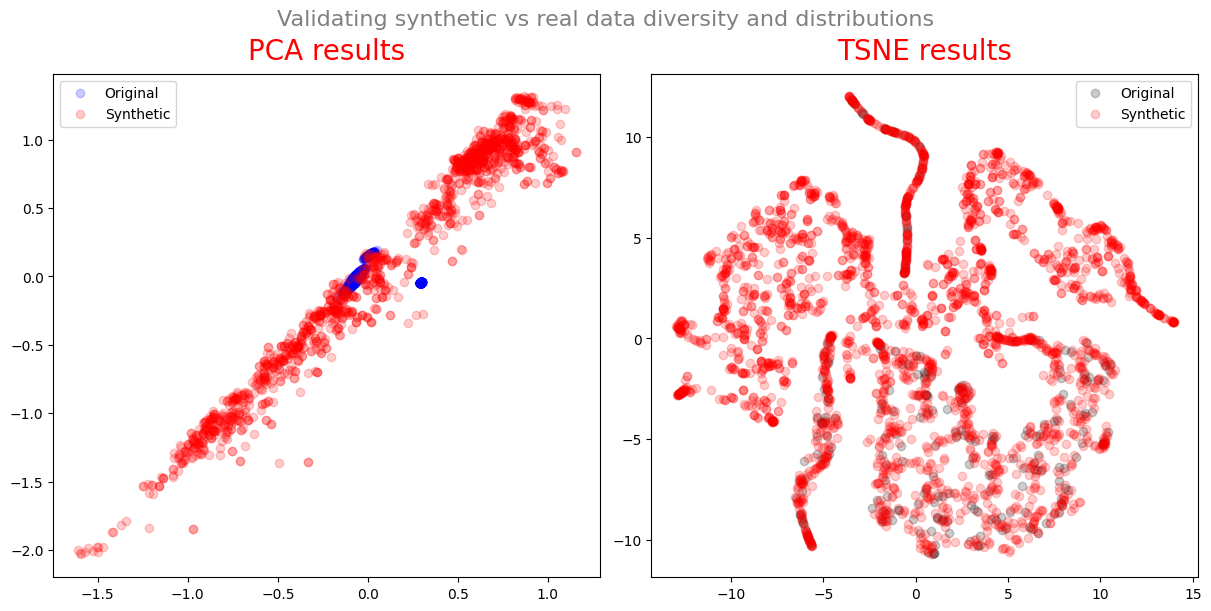

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(12,6))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='blue', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

# Exps

In [ ]:
def net(model, n_layers, hidden_units, output_units, net_type='GRU'):
    if net_type=='GRU':
        for i in range(n_layers):
            model.add(GRU(units=hidden_units,
                      return_sequences=True,
                      name=f'GRU_{i + 1}'))
    else:
        for i in range(n_layers):
            model.add(LSTM(units=hidden_units,
                      return_sequences=True,
                      name=f'LSTM_{i + 1}'))
    model.add(Dense(units=output_units,
                    activation='sigmoid',
                    name='OUT'))
    return model
class Generator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type = net_type
    def build(self, input_shape):
        model = Sequential(name='Generator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim,
                    net_type=self.net_type)
        return model
class Discriminator(Model):
    def __init__(self, hidden_dim, net_type='GRU'):
        self.hidden_dim = hidden_dim
        self.net_type=net_type
    def build(self, input_shape):
        model = Sequential(name='Discriminator')
        model = net(model,
                    n_layers=3,
                    hidden_units=self.hidden_dim,
                    output_units=1,
                    net_type=self.net_type)
        return model
class Recovery(Model):
    def __init__(self, hidden_dim, n_seq):
        self.hidden_dim=hidden_dim
        self.n_seq=n_seq
        return
    def build(self, input_shape):
        recovery = Sequential(name='Recovery')
        recovery = net(recovery,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.n_seq)
        return recovery
class Embedder(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
        return
    def build(self, input_shape):
        embedder = Sequential(name='Embedder')
        embedder = net(embedder,
                       n_layers=3,
                       hidden_units=self.hidden_dim,
                       output_units=self.hidden_dim)
        return embedder
class Supervisor(Model):
    def __init__(self, hidden_dim):
        self.hidden_dim=hidden_dim
    def build(self, input_shape):
        model = Sequential(name='Supervisor')
        model = net(model,
                    n_layers=2,
                    hidden_units=self.hidden_dim,
                    output_units=self.hidden_dim)
        return model
class TimeGAN():
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        self.seq_len=seq_len
        self.batch_size, self.lr, self.beta_1, self.beta_2, self.noise_dim, self.data_dim, self.layers_dim = model_parameters
        self.n_seq=n_seq
        self.hidden_dim=hidden_dim
        self.gamma=gamma
        self.define_gan()
    def define_gan(self):
        self.generator_aux=Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        self.supervisor=Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.discriminator=Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))
        X = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RealData')
        Z = Input(shape=[self.seq_len, self.n_seq], batch_size=self.batch_size, name='RandomNoise')
        H = self.embedder(X)
        X_tilde = self.recovery(H)
        self.autoencoder = Model(inputs=X, outputs=X_tilde)
        E_Hat = self.generator_aux(Z)
        H_hat = self.supervisor(E_Hat)
        Y_fake = self.discriminator(H_hat)
        self.adversarial_supervised = Model(inputs=Z,
                                       outputs=Y_fake,
                                       name='AdversarialSupervised')
        Y_fake_e = self.discriminator(E_Hat)
        self.adversarial_embedded = Model(inputs=Z,
                                    outputs=Y_fake_e,
                                    name='AdversarialEmbedded')
        X_hat = self.recovery(H_hat)
        self.generator = Model(inputs=Z,
                            outputs=X_hat,
                            name='FinalGenerator')
        Y_real = self.discriminator(H)
        self.discriminator_model = Model(inputs=X,
                                         outputs=Y_real,
                                         name="RealDiscriminator")
        self._mse=MeanSquaredError()
        self._bce=BinaryCrossentropy()
class TimeGAN(TimeGAN):
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        super().__init__(model_parameters, hidden_dim, seq_len, n_seq, gamma)
    @function
    def train_autoencoder(self, x, opt):
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)
        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)
    @function
    def train_supervisor(self, x, z, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            e_hat = self.generator_aux(z)
            h_hat_supervised = self.supervisor(e_hat)
            g_loss_s = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s
    @function
    def train_embedder(self,x, opt):
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised
        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)
    def discriminator_loss(self, x, z):
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real),
                                            y_pred=y_real)
        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake),
                                            y_pred=y_fake)
        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e),
                                              y_pred=y_fake_e)
        return (discriminator_loss_real +
                discriminator_loss_fake +
                self.gamma * discriminator_loss_fake_e)
    @staticmethod
    def calc_generator_moments_loss(y_true, y_pred):
        y_true_mean, y_true_var = nn.moments(x=y_true, axes=[0])
        y_pred_mean, y_pred_var = nn.moments(x=y_pred, axes=[0])
        g_loss_mean = reduce_mean(abs(y_true_mean - y_pred_mean))
        g_loss_var = reduce_mean(abs(sqrt(y_true_var + 1e-6) - sqrt(y_pred_var + 1e-6)))
        return g_loss_mean + g_loss_var
    @function
    def train_generator(self, x, z, opt):
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake),
                                                    y_pred=y_fake)
            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e),
                                                      y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)
            generator_loss = (generator_loss_unsupervised +
                              generator_loss_unsupervised_e +
                              100 * sqrt(generator_loss_supervised) +
                              100 * generator_moment_loss)
        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss
    @function
    def train_discriminator(self, x, z, opt):
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)
        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss
    def get_batch_data(self, data, n_windows):
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data)
                                .shuffle(buffer_size=n_windows)
                                .batch(self.batch_size).repeat())
    def _generate_noise(self):
        while True:
            yield np.random.uniform(low=0, high=1, size=(self.seq_len, self.n_seq))
    def get_batch_noise(self):
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32)
                                .batch(self.batch_size)
                                .repeat())
    def sample(self, n_samples):
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))
gan_args = 128, 5e-4, 32, 24, 2, (0, 1), 128
synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=24, n_seq=6, gamma=1)
supervisor_opt = Adam(learning_rate=5e-4)
loss = []
for _ in tqdm(range(train_steps), desc='Supervised network training'):
    X_ = next(synth.get_batch_data(stock_data, n_windows=len(stock_data)))
    Z_ = next(synth.get_batch_noise())
    step_g_loss_s = synth.train_supervisor(X_, Z_, supervisor_opt)
    loss.append(step_g_loss_s)

Supervised network training: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]


In [ ]:
px.line(np.array(loss))

In [ ]:
px.line(np.array(loss))

In [ ]:
"""
Time-series Generative Adversarial Networks (TimeGAN) Implementation.

This code implements a TimeGAN model, which is a type of Generative Adversarial Network (GAN) designed for generating realistic time-series data.
The model consists of a generator network, a discriminator network, an autoencoder network, and a supervisor network.
The generator network generates synthetic time-series data, the discriminator network tries to distinguish between real and synthetic data,
the autoencoder network is used for embedding the input data, and the supervisor network is used to predict the next time step's latent representation.

Attributes:
    - seq_len (int): The length of the input sequence.
    - n_seq (int): The number of sequences in the input data.
    - hidden_dim (int): The number of units in the hidden layers of the networks.
    - gamma (float): The coefficient for the moment loss in the generator loss function.
    - model_parameters (tuple): A tuple containing the parameters for the model, including the batch size, learning rate, beta 1, beta 2, noise dimension, and data dimension.
    - generator_aux (Model): The auxiliary generator network.
    - supervisor (Model): The supervisor network.
    - discriminator (Model): The discriminator network.
    - recovery (Model): The recovery network.
    - embedder (Model): The embedder network.
    - autoencoder (Model): The autoencoder network.
    - adversarial_supervised (Model): The adversarial supervised network.
    - adversarial_embedded (Model): The adversarial embedded network.
    - generator (Model): The generator network.
    - discriminator_model (Model): The discriminator model.

Methods:
    - define_gan: Defines the TimeGAN model architecture.
    - train_autoencoder: Trains the autoencoder network.
    - train_supervisor: Trains the supervisor network.
    - train_embedder: Trains the embedder network.
    - discriminator_loss: Calculates the discriminator loss.
    - train_generator: Trains the generator network.
    - train_discriminator: Trains the discriminator network.
    - get_batch_data: Gets a batch of data from the input data.
    - get_batch_noise: Gets a batch of noise from a uniform distribution.
    - sample: Generates synthetic time-series data using the generator network.
"""

class TimeGAN:
    def __init__(self, model_parameters, hidden_dim, seq_len, n_seq, gamma):
        """
        Initializes the TimeGAN model.

        Args:
            model_parameters (tuple): A tuple containing the parameters for the model.
            hidden_dim (int): The number of units in the hidden layers of the networks.
            seq_len (int): The length of the input sequence.
            n_seq (int): The number of sequences in the input data.
            gamma (float): The coefficient for the moment loss in the generator loss function.
        """
        self.seq_len = seq_len
        self.n_seq = n_seq
        self.hidden_dim = hidden_dim
        self.gamma = gamma
        self.model_parameters = model_parameters
        self.define_gan()

    def define_gan(self):
        """
        Defines the TimeGAN model architecture.
        """
        # Define the generator auxiliary network
        self.generator_aux = Generator(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        # Define the supervisor network
        self.supervisor = Supervisor(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))

        # Define the discriminator network
        self.discriminator = Discriminator(self.hidden_dim).build(input_shape=(self.hidden_dim, self.hidden_dim))

        # Define the recovery network
        self.recovery = Recovery(self.hidden_dim, self.n_seq).build(input_shape=(self.hidden_dim, self.hidden_dim))

        # Define the embedder network
        self.embedder = Embedder(self.hidden_dim).build(input_shape=(self.seq_len, self.n_seq))

        # Define the autoencoder network
        self.autoencoder = Model(inputs=X, outputs=X_tilde)

        # Define the adversarial supervised network
        self.adversarial_supervised = Model(inputs=Z, outputs=Y_fake)

        # Define the adversarial embedded network
        self.adversarial_embedded = Model(inputs=Z, outputs=Y_fake_e)

        # Define the generator network
        self.generator = Model(inputs=Z, outputs=X_hat)

        # Define the discriminator model
        self.discriminator_model = Model(inputs=X, outputs=Y_real)

    def train_autoencoder(self, x, opt):
        """
        Trains the autoencoder network.

        Args:
            x (tensor): The input data.
            opt (optimizer): The optimizer for the autoencoder network.

        Returns:
            loss (float): The loss of the autoencoder network.
        """
        with GradientTape() as tape:
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss_0 = 10 * sqrt(embedding_loss_t0)
        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss_0, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def train_supervisor(self, x, z, opt):
        """
        Trains the supervisor network.

        Args:
            x (tensor): The input data.
            z (tensor): The noise data.
            opt (optimizer): The optimizer for the supervisor network.

        Returns:
            loss (float): The loss of the supervisor network.
        """
        with GradientTape() as tape:
            h = self.embedder(x)
            e_hat = self.generator_aux(z)
            h_hat_supervised = self.supervisor(e_hat)
            g_loss_s = self._mse(h[:, :-1, :], h_hat_supervised[:, 1:, :])
        var_list = self.supervisor.trainable_variables + self.generator.trainable_variables
        gradients = tape.gradient(g_loss_s, var_list)
        apply_grads = [(grad, var) for (grad, var) in zip(gradients, var_list) if grad is not None]
        opt.apply_gradients(apply_grads)
        return g_loss_s

    def train_embedder(self, x, opt):
        """
        Trains the embedder network.

        Args:
            x (tensor): The input data.
            opt (optimizer): The optimizer for the embedder network.

        Returns:
            loss (float): The loss of the embedder network.
        """
        with GradientTape() as tape:
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
            x_tilde = self.autoencoder(x)
            embedding_loss_t0 = self._mse(x, x_tilde)
            e_loss = 10 * sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised
        var_list = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(e_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return sqrt(embedding_loss_t0)

    def discriminator_loss(self, x, z):
        """
        Calculates the discriminator loss.

        Args:
            x (tensor): The input data.
            z (tensor): The noise data.

        Returns:
            loss (float): The loss of the discriminator network.
        """
        y_real = self.discriminator_model(x)
        discriminator_loss_real = self._bce(y_true=ones_like(y_real), y_pred=y_real)
        y_fake = self.adversarial_supervised(z)
        discriminator_loss_fake = self._bce(y_true=zeros_like(y_fake), y_pred=y_fake)
        y_fake_e = self.adversarial_embedded(z)
        discriminator_loss_fake_e = self._bce(y_true=zeros_like(y_fake_e), y_pred=y_fake_e)
        return (discriminator_loss_real + discriminator_loss_fake + self.gamma * discriminator_loss_fake_e)

    def train_generator(self, x, z, opt):
        """
        Trains the generator network.

        Args:
            x (tensor): The input data.
            z (tensor): The noise data.
            opt (optimizer): The optimizer for the generator network.

        Returns:
            loss (float): The loss of the generator network.
        """
        with GradientTape() as tape:
            y_fake = self.adversarial_supervised(z)
            generator_loss_unsupervised = self._bce(y_true=ones_like(y_fake), y_pred=y_fake)
            y_fake_e = self.adversarial_embedded(z)
            generator_loss_unsupervised_e = self._bce(y_true=ones_like(y_fake_e), y_pred=y_fake_e)
            h = self.embedder(x)
            h_hat_supervised = self.supervisor(h)
            generator_loss_supervised = self._mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])
            x_hat = self.generator(z)
            generator_moment_loss = self.calc_generator_moments_loss(x, x_hat)
            generator_loss = (generator_loss_unsupervised + generator_loss_unsupervised_e + 100 * sqrt(generator_loss_supervised) + 100 * generator_moment_loss)
        var_list = self.generator_aux.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(generator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

    def train_discriminator(self, x, z, opt):
        """
        Trains the discriminator network.

        Args:
            x (tensor): The input data.
            z (tensor): The noise data.
            opt (optimizer): The optimizer for the discriminator network.

        Returns:
            loss (float): The loss of the discriminator network.
        """
        with GradientTape() as tape:
            discriminator_loss = self.discriminator_loss(x, z)
        var_list = self.discriminator.trainable_variables
        gradients = tape.gradient(discriminator_loss, var_list)
        opt.apply_gradients(zip(gradients, var_list))
        return discriminator_loss

    def get_batch_data(self, data, n_windows):
        """
        Gets a batch of data from the input data.

        Args:
            data (array): The input data.
            n_windows (int): The number of windows in the input data.

        Returns:
            batch_data (tensor): A batch of data from the input data.
        """
        data = convert_to_tensor(data, dtype=float32)
        return iter(tfdata.Dataset.from_tensor_slices(data).shuffle(buffer_size=n_windows).batch(self.batch_size).repeat())

    def get_batch_noise(self):
        """
        Gets a batch of noise from a uniform distribution.

        Returns:
            batch_noise (tensor): A batch of noise from a uniform distribution.
        """
        return iter(tfdata.Dataset.from_generator(self._generate_noise, output_types=float32).batch(self.batch_size).repeat())

    def sample(self, n_samples):
        """
        Generates synthetic time-series data using the generator network.

        Args:
            n_samples (int): The number of samples to generate.

        Returns:
            synthetic_data (array): The generated synthetic time-series data.
        """
        steps = n_samples // self.batch_size + 1
        data = []
        for _ in trange(steps, desc='Synthetic data generation'):
            Z_ = next(self.get_batch_noise())
            records = self.generator(Z_)
            data.append(records)
        return np.array(np.vstack(data))